In [1]:
import codecs
import numpy as np
import copy
import time
import random

In [2]:
entities2id = {}
relations2id = {}

id2entity = {}

In [3]:
LOSS_LS = []

In [4]:
word2vec = {}
pre_path = '../../TCM embedding/result/TCM_w2v.txt'
    
with codecs.open(pre_path, 'r', 'utf-8') as input_data:
    for line in input_data.readlines():
        word2vec[line.split()[0]] = [float(i) for i in list(line.split()[1:])]


In [5]:
def dataloader(file1, file2, file3):
    print("load file...")

    entity = []
    relation = []
    
    with open(file2, 'r',encoding="utf-8") as f1, open(file3, 'r',encoding="utf-8") as f2:
        lines1 = f1.readlines()
        lines2 = f2.readlines()
        for line in lines1:
            line = line.strip().split('\t')
            if len(line) != 2:
                continue
            entities2id[line[0]] = int(line[1])
            entity.append(line[1])

        for line in lines2:
            line = line.strip().split('\t')
            if len(line) != 2:
                continue
            relations2id[line[0]] = int(line[1])
            relation.append(line[1])


    triple_list = []

    with codecs.open(file1, 'r',encoding = "utf-8") as f:
        content = f.readlines()
        for line in content:
            triple = line.strip().split("\t")
            if len(triple) != 3:
                continue
            h_ = entities2id[triple[0]]
            r_ = relations2id[triple[1]]
            t_ = entities2id[triple[2]]


            triple_list.append([h_, r_, t_])

    print("Complete load. entity : %d , relation : %d , triple : %d" % (
    len(entity), len(relation), len(triple_list)))
    id2entity = {v:k for k,v in entities2id.items()}
    return entity, relation, triple_list,id2entity

In [6]:
def norm_l1(h, r, t):
    return np.sum(np.fabs(h + r - t))

In [7]:
def norm_l2(h, r, t):
    return np.sum(np.square(h + r - t))

In [8]:
class TransE:
    def __init__(self, entity, relation, triple_list, embedding_dim=200, lr=0.01, margin=1.0, norm=1):
        self.entities = entity
        self.relations = relation
        self.triples = triple_list
        self.dimension = embedding_dim
        self.learning_rate = lr
        self.margin = margin
        self.norm = norm
        self.loss = 0.0

    def data_initialise(self):
        entityVectorList = {}
        relationVectorList = {}
        for entity in self.entities:
            ##print("entity",entity)##
            #entity_vector = np.random.uniform(-6.0 / np.sqrt(self.dimension), 6.0 / np.sqrt(self.dimension),
            #                                  self.dimension)
            word_entity = id2entity[int(entity)]
            entity_vector = np.zeros(self.dimension)
            for char in word_entity:
                try:
                    entity_vector += word2vec[char]
                except:
                    entity_vector += np.random.uniform(-6.0 / np.sqrt(self.dimension), 6.0 / np.sqrt(self.dimension),
                                              self.dimension)
            entityVectorList[int(entity)] = np.asarray(entity_vector)

        for relation in self.relations:
            ##print("entity",relation)##
            relation_vector = np.random.uniform(-6.0 / np.sqrt(self.dimension), 6.0 / np.sqrt(self.dimension),
                                                self.dimension)
            
            relation_vector = self.normalization(relation_vector)
            relationVectorList[int(relation)] = relation_vector

        self.entities = entityVectorList
        self.relations = relationVectorList
        print("entityVectorList:",entityVectorList[0].shape)
        print("relationVectorList:",relationVectorList[0].shape)
        
    def normalization(self, vector):
        return vector / np.linalg.norm(vector)

    def training_run(self, epochs=30, nbatches=100, out_file_title = ''):

        batch_size = int(len(self.triples) / nbatches)
        print("batch size: ", batch_size)
        for epoch in range(epochs):
            start = time.time()
            self.loss = 0.0
            # Normalise the embedding of the entities to 1
            for entity in self.entities.keys():
                self.entities[entity] = self.normalization(self.entities[entity]);

            for batch in range(nbatches):
                batch_samples = random.sample(self.triples, batch_size)

                Tbatch = []
                for sample in batch_samples:
                    corrupted_sample = copy.deepcopy(sample)
                    pr = np.random.random(1)[0]
                    if pr > 0.5:
                        # change the head entity
                        corrupted_sample[0] = random.sample(self.entities.keys(), 1)[0]
                        while corrupted_sample[0] == sample[0]:
                            corrupted_sample[0] = random.sample(self.entities.keys(), 1)[0]
                    else:
                        # change the tail entity
                        corrupted_sample[2] = random.sample(self.entities.keys(), 1)[0]
                        while corrupted_sample[2] == sample[2]:
                            corrupted_sample[2] = random.sample(self.entities.keys(), 1)[0]
                    if (sample, corrupted_sample) not in Tbatch:
                        Tbatch.append((sample, corrupted_sample))

                self.update_triple_embedding(Tbatch)
            end = time.time()
            print("epoch: ", epoch, "cost time: %s" % (round((end - start), 3)))
            print("running loss: ", self.loss)
            LOSS_LS.append(self.loss)

        with codecs.open(out_file_title +"TransE_entity_" + str(self.dimension) + "dim_batch" + str(batch_size), "w") as f1:

            for e in self.entities.keys():
                # f1.write("\t")
                # f1.write(e + "\t")
                f1.write(str(list(self.entities[e])))
                f1.write("\n")

        with codecs.open(out_file_title +"TransE_relation_" + str(self.dimension) + "dim_batch" + str(batch_size), "w") as f2:
            for r in self.relations.keys():
                # f2.write("\t")
                # f2.write(r + "\t")
                f2.write(str(list(self.relations[r])))
                f2.write("\n")

    def update_triple_embedding(self, Tbatch):
        # deepcopy 可以保证，即使list嵌套list也能让各层的地址不同， 即这里copy_entity 和
        # entitles中所有的elements都不同
        copy_entity = copy.deepcopy(self.entities)
        copy_relation = copy.deepcopy(self.relations)

        for correct_sample, corrupted_sample in Tbatch:
            correct_copy_head = copy_entity[correct_sample[0]]
            correct_copy_tail = copy_entity[correct_sample[2]]
            relation_copy = copy_relation[correct_sample[1]]

            corrupted_copy_head = copy_entity[corrupted_sample[0]]
            corrupted_copy_tail = copy_entity[corrupted_sample[2]]

            correct_head = self.entities[correct_sample[0]]
            correct_tail = self.entities[correct_sample[2]]
            relation = self.relations[correct_sample[1]]

            corrupted_head = self.entities[corrupted_sample[0]]
            corrupted_tail = self.entities[corrupted_sample[2]]

            # calculate the distance of the triples
            if self.norm == 1:
                correct_distance = norm_l1(correct_head, relation, correct_tail)
                corrupted_distance = norm_l1(corrupted_head, relation, corrupted_tail)

            else:
                correct_distance = norm_l2(correct_head, relation, correct_tail)
                corrupted_distance = norm_l2(corrupted_head, relation, corrupted_tail)

            loss = self.margin + correct_distance - corrupted_distance

            if loss > 0:
                self.loss += loss
                #print("loss:",loss)
                correct_gradient = 2 * (correct_head + relation - correct_tail)
                corrupted_gradient = 2 * (corrupted_head + relation - corrupted_tail)

                if self.norm == 1:
                    for i in range(len(correct_gradient)):
                        if correct_gradient[i] > 0:
                            correct_gradient[i] = 1
                        else:
                            correct_gradient[i] = -1

                        if corrupted_gradient[i] > 0:
                            corrupted_gradient[i] = 1
                        else:
                            corrupted_gradient[i] = -1

                correct_copy_head -= self.learning_rate * correct_gradient
                relation_copy -= self.learning_rate * correct_gradient
                correct_copy_tail -= -1 * self.learning_rate * correct_gradient

                relation_copy -= -1 * self.learning_rate * corrupted_gradient
                if correct_sample[0] == corrupted_sample[0]:
                    # if corrupted_triples replaces the tail entity, the head entity's embedding need to be updated twice
                    correct_copy_head -= -1 * self.learning_rate * corrupted_gradient
                    corrupted_copy_tail -= self.learning_rate * corrupted_gradient
                elif correct_sample[2] == corrupted_sample[2]:
                    # if corrupted_triples replaces the head entity, the tail entity's embedding need to be updated twice
                    corrupted_copy_head -= -1 * self.learning_rate * corrupted_gradient
                    correct_copy_tail -= self.learning_rate * corrupted_gradient

                # normalising these new embedding vector, instead of normalising all the embedding together
                copy_entity[correct_sample[0]] = self.normalization(correct_copy_head)
                copy_entity[correct_sample[2]] = self.normalization(correct_copy_tail)
                if correct_sample[0] == corrupted_sample[0]:
                    # if corrupted_triples replace the tail entity, update the tail entity's embedding
                    copy_entity[corrupted_sample[2]] = self.normalization(corrupted_copy_tail)
                elif correct_sample[2] == corrupted_sample[2]:
                    # if corrupted_triples replace the head entity, update the head entity's embedding
                    copy_entity[corrupted_sample[0]] = self.normalization(corrupted_copy_head)
                # the paper mention that the relation's embedding don't need to be normalised
                copy_relation[correct_sample[1]] = relation_copy
                # copy_relation[correct_sample[1]] = self.normalization(relation_copy)

        self.entities = copy_entity
        self.relations = copy_relation

In [9]:
location = './'
file1 = "../data/triple_KE-simplified.txt"
file2 = "../data/entity2id.txt"
file3 = "../data/relation2id.txt"

entity_set, relation_set, triple_list , id2entity = dataloader(file1, file2, file3)
    
# modify by yourself
transE = TransE(entity_set, relation_set, triple_list, embedding_dim=200, lr=0.01, margin=1.0, norm=2)
transE.data_initialise()
transE.training_run(out_file_title="qianjinfang_")

load file...
Complete load. entity : 463 , relation : 5 , triple : 1573
entityVectorList: (200,)
relationVectorList: (200,)
batch size:  15
epoch:  0 cost time: 0.244
running loss:  811.6605495113873
epoch:  1 cost time: 0.235
running loss:  496.2576237111866
epoch:  2 cost time: 0.254
running loss:  391.5193399615886
epoch:  3 cost time: 0.239
running loss:  334.438812168076
epoch:  4 cost time: 0.295
running loss:  328.6321662235757
epoch:  5 cost time: 0.235
running loss:  298.31971473384374
epoch:  6 cost time: 0.231
running loss:  267.91664440971294
epoch:  7 cost time: 0.273
running loss:  281.53117294194834
epoch:  8 cost time: 0.19
running loss:  255.06154891631388
epoch:  9 cost time: 0.222
running loss:  269.9876303391885
epoch:  10 cost time: 0.229
running loss:  262.0020055491269
epoch:  11 cost time: 0.193
running loss:  213.62501664641803
epoch:  12 cost time: 0.25
running loss:  212.2932419591822
epoch:  13 cost time: 0.199
running loss:  205.23733223915764
epoch:  14 co

In [10]:
LOSS_LS

[811.6605495113873,
 496.2576237111866,
 391.5193399615886,
 334.438812168076,
 328.6321662235757,
 298.31971473384374,
 267.91664440971294,
 281.53117294194834,
 255.06154891631388,
 269.9876303391885,
 262.0020055491269,
 213.62501664641803,
 212.2932419591822,
 205.23733223915764,
 220.24243519117027,
 215.90378878174488,
 199.2514666331424,
 174.55659173147828,
 195.83349654370284,
 198.99777819152737,
 190.55401233142553,
 176.24154475874363,
 163.47206178970922,
 146.44520965168908,
 158.15124467760947,
 137.6502875390069,
 128.91297546311847,
 134.28032932614693,
 139.18189084009674,
 142.5856890574975]

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['simsun'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

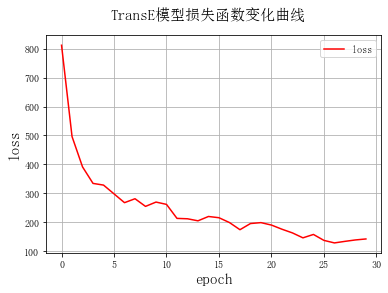

In [12]:
fig, ax = plt.subplots()#创建一个figure 
ax.plot(LOSS_LS, '-r',label='loss')
####打开网格
ax.grid(True)

####定义x, y轴的名称
ax.set_xlabel('epoch',fontsize=15)
ax.set_ylabel('loss',fontsize=15)

####定义标题
fig.suptitle('TransE模型损失函数变化曲线',fontsize=15)

####展示图例 legend loc=是用来定义图例的位置的，还有很多选择，大家可以自己尝试
ax.legend(loc = 'upper right')

plt.savefig("TransE模型损失函数变化曲线")